<a href="https://colab.research.google.com/github/adityachanna/DataAnalysis/blob/main/Aditya_Channa_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

## Data Loading and Feature Exraction

In [17]:
transactions = pd.read_csv('Transactions.csv', parse_dates=['TransactionDate'])
customers = pd.read_csv('Customers.csv', parse_dates=['SignupDate'])
max_transaction_date = transactions['TransactionDate'].max()
customers['Tenure'] = (max_transaction_date - customers['SignupDate']).dt.days
agg_transactions = transactions.groupby('CustomerID').agg(
    Total_transactions=('TransactionID', 'count'),
    Total_spent=('TotalValue', 'sum'),
    Last_transaction=('TransactionDate', 'max'),
    Product_diversity=('ProductID', 'nunique')
).reset_index()
agg_transactions['Average_transaction_value'] = agg_transactions['Total_spent'] / agg_transactions['Total_transactions']
agg_transactions['Recency'] = (max_transaction_date - agg_transactions['Last_transaction']).dt.days
merged_df = pd.merge(customers, agg_transactions, on='CustomerID', how='inner')
features = merged_df[['Region', 'Tenure', 'Total_transactions', 'Total_spent', 'Average_transaction_value', 'Recency', 'Product_diversity']]
features_encoded = pd.get_dummies(features, columns=['Region'])

## Scaling data

In [18]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_encoded)

## Checking which is best number of clusters


In [19]:
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, clusters))
optimal_k = np.argmin(db_scores) + 2

## Optimal K Prediction

In [20]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette = silhouette_score(scaled_features, clusters)

## Visualizing Clusters using PCA and Report of Scores


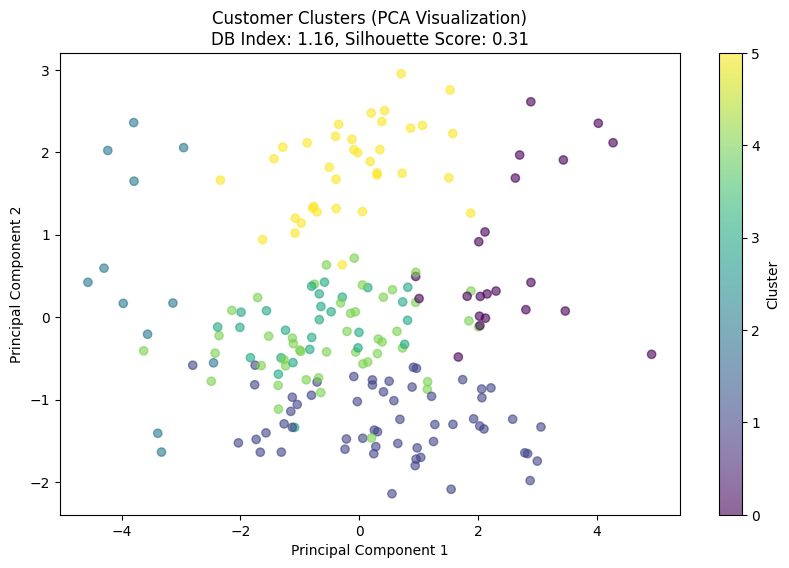


Number of clusters: 6
Davies-Bouldin Index: 1.1596
Silhouette Score: 0.3101


In [21]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title(f'Customer Clusters (PCA Visualization)\nDB Index: {db_index:.2f}, Silhouette Score: {silhouette:.2f}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()
print(f"\nNumber of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")